# Assignment 2: recommender System

## Code from the lecture

In [186]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [187]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [188]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [189]:
%%time
#again, implementation not efficient: better use lamda opperators 
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

Wall time: 3min 21s


In [190]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [191]:
CII("Star Wars",D)

recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
126              Godfather, The (1972)
Name: title, dtype: object

(array([ 18.,  43., 114., 143., 158., 156., 144., 102.,  51.,  14.]),
 array([0.   , 0.476, 0.952, 1.428, 1.904, 2.38 , 2.856, 3.332, 3.808,
        4.284, 4.76 ]),
 <BarContainer object of 10 artists>)

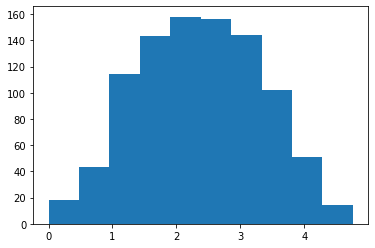

In [192]:
test_res = test_Score(D,R)
plt.hist(test_res)

In [193]:
np.mean(test_res)

2.3701802757158004

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [194]:
def EucledianDist(a,b):
    return np.linalg.norm(a-b)

In [195]:
#%%time
#again, implementation not efficient: better use lamda opperators 
D_Euclidian=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_Euclidian[i,j]=EucledianDist(R[:,i],R[:,j])

In [196]:
CII("Star Wars",D_Euclidian)

recommending movies for: 'Star Wars (1977)'


989              Anna Karenina (1997)
1061    Four Days in September (1997)
1126          Truman Show, The (1998)
937        Smile Like Yours, A (1997)
1242               Night Flier (1997)
Name: title, dtype: object

(array([236., 129., 137., 120., 126.,  81.,  61.,  31.,  17.,   5.]),
 array([0.   , 0.484, 0.968, 1.452, 1.936, 2.42 , 2.904, 3.388, 3.872,
        4.356, 4.84 ]),
 <BarContainer object of 10 artists>)

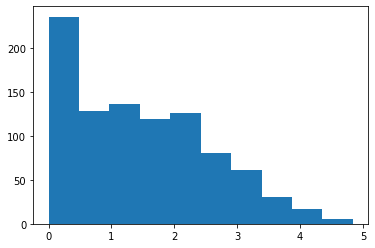

In [197]:
test_res = test_Score(D_Euclidian,R)
plt.hist(test_res)

In [198]:
np.mean(test_res)

1.4630328738069989

Wir können hier merken, dass der Score deutlich niedriger ist als die Cosinus Distance.
Die Recommended Filme haben auch keine Beziehung zu den gewählten Film

## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

# Random recommendations

In [199]:
def getRandomID():
    return np.random.randint(0,np.shape(movies)[0],size = 5)

In [200]:
def CII_Random(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getRandomID())[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")

In [201]:
CII_Random("Star Wars")

recommending movies for: 'Star Wars (1977)'


774           Something to Talk About (1995)
551                           Species (1995)
955                     Nobody's Fool (1994)
229     Star Trek IV: The Voyage Home (1986)
1465                Margaret's Museum (1995)
Name: title, dtype: object

In [202]:
CII_Random("Contact")

recommending movies for: 'Star Trek: First Contact (1996)'


1673               Mamma Roma (1962)
544       Vampire in Brooklyn (1995)
1308    Very Natural Thing, A (1974)
1399            Picture Bride (1995)
891                   Flubber (1997)
Name: title, dtype: object

Wir merken dass die Filme keine Beziehungen haben zwischeneinander, wegen den Random

# Top 5 Movies

In [203]:
def getTop5():
    return np.mean(R,axis=0)

In [204]:
def CII_Top5(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(np.argsort(getTop5())[-5:])[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")

In [205]:
CII_Top5("Star Wars")

recommending movies for: 'Star Wars (1977)'


49                   Star Wars (1977)
99                       Fargo (1996)
180         Return of the Jedi (1983)
257                    Contact (1997)
173    Raiders of the Lost Ark (1981)
Name: title, dtype: object

In [206]:
CII_Top5("Contact")

recommending movies for: 'Star Trek: First Contact (1996)'


49                   Star Wars (1977)
99                       Fargo (1996)
180         Return of the Jedi (1983)
257                    Contact (1997)
173    Raiders of the Lost Ark (1981)
Name: title, dtype: object

Wir sehen hier dass die Recommended Filme sind immer die selbe und diese von Top5

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


In [207]:
U_SVD, D_SVD, V_SVD = np.linalg.svd(D, full_matrices = False)

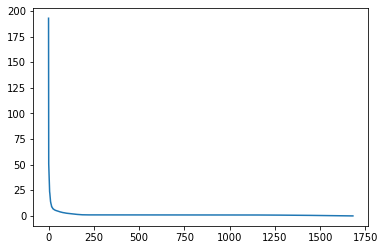

In [208]:
plt.plot(D_SVD)

In [209]:
D_SVDReconstruct = np.matrix(U_SVD[:, :100]) * np.diag(D_SVD[:100]) * np.matrix(V_SVD[:100, :])

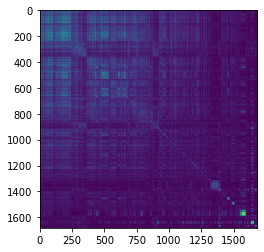

In [210]:
plt.imshow(D)

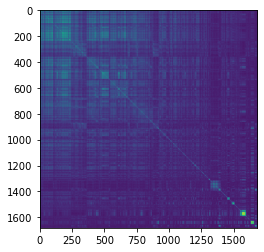

In [211]:
plt.imshow(D_SVDReconstruct)

In [212]:
#Suppression of negative entries
D_SVDReconstruct = np.where(D_SVDReconstruct < 0,0,D_SVDReconstruct)

In [213]:
CII("Star Wars", D_SVDReconstruct)

recommending movies for: 'Star Wars (1977)'


49                    Star Wars (1977)
180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
Name: title, dtype: object

(array([ 30.,  64., 116., 116., 126., 144., 139., 116.,  78.,  14.]),
 array([0.96 , 1.352, 1.744, 2.136, 2.528, 2.92 , 3.312, 3.704, 4.096,
        4.488, 4.88 ]),
 <BarContainer object of 10 artists>)

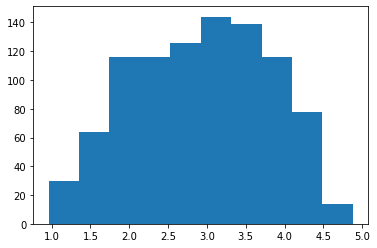

In [214]:
test_res = test_Score(D_SVDReconstruct,R)
plt.hist(test_res)

In [215]:
np.mean(test_res)

2.9261081654294805

Wir sehen dass die Singular Value Decomposition ist deutlich schneller und liefert fast das selbe Resultate als die originale Methode. In disem Fall, mit ein Slicing von 100, ist das Resultat noch besser